In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("en_vi_bidirectional.csv")

print("Total pairs:", len(df))
df.head()

In [ ]:
# Create bidirectional data with language tokens
# EN→VI: [VI] english_text → vietnamese_text
# VI→EN: [EN] vietnamese_text → english_text

df_en_vi = pd.DataFrame({
    "src": "[VI] " + df["src"].astype(str),
    "tgt": df["tgt"].astype(str)
})

df_vi_en = pd.DataFrame({
    "src": "[EN] " + df["tgt"].astype(str),
    "tgt": df["src"].astype(str)
})

df_bidirectional = pd.concat([df_en_vi, df_vi_en], ignore_index=True)
print("Bidirectional pairs:", len(df_bidirectional))
df_bidirectional.head()

In [ ]:
# Simple token count (whitespace-based)
df_bidirectional["src_len"] = df_bidirectional["src"].astype(str).str.split().apply(len)
df_bidirectional["tgt_len"] = df_bidirectional["tgt"].astype(str).str.split().apply(len)

df_bidirectional[["src_len", "tgt_len"]].describe()

In [ ]:
bins = [0, 10, 20, 30, 50, 1000]
bin_labels = ["1–10", "11–20", "21–30", "31–50", "51+"]

df_bidirectional["len_bin"] = pd.cut(
    df_bidirectional["src_len"],
    bins=bins,
    labels=bin_labels,
    right=True
)

df_bidirectional["len_bin"].value_counts(normalize=True).sort_index()

In [5]:
VAL_SIZE = 5000
RANDOM_SEED = 42


In [ ]:
val_indices = []

for bin_label in bin_labels:
    bin_df = df_bidirectional[df_bidirectional["len_bin"] == bin_label]
    
    if len(bin_df) == 0:
        continue
    
    # Proportional sampling
    n_bin = int(len(bin_df) / len(df_bidirectional) * VAL_SIZE)
    n_bin = max(n_bin, 1)  # ensure coverage
    
    sampled = bin_df.sample(
        n=n_bin,
        random_state=RANDOM_SEED
    )
    
    val_indices.extend(sampled.index)

# Create splits
df_val = df_bidirectional.loc[val_indices].copy()
df_train = df_bidirectional.drop(index=val_indices).copy()

print("Train size:", len(df_train))
print("Val size:", len(df_val))

In [ ]:
import os
os.makedirs("cleaned_data", exist_ok=True)

df_train[["src", "tgt"]].to_csv(
    "cleaned_data/train.csv",
    index=False,
    encoding="utf-8"
)

df_val[["src", "tgt"]].to_csv(
    "cleaned_data/val.csv",
    index=False,
    encoding="utf-8"
)

print("Saved train.csv and val.csv to cleaned_data/")

In [8]:
def plot_len_dist(train, val, column, title):
    plt.figure(figsize=(8, 5))
    
    plt.hist(
        train[column],
        bins=50,
        alpha=0.6,
        label="Train",
        density=True
    )
    plt.hist(
        val[column],
        bins=50,
        alpha=0.6,
        label="Validation",
        density=True
    )
    
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


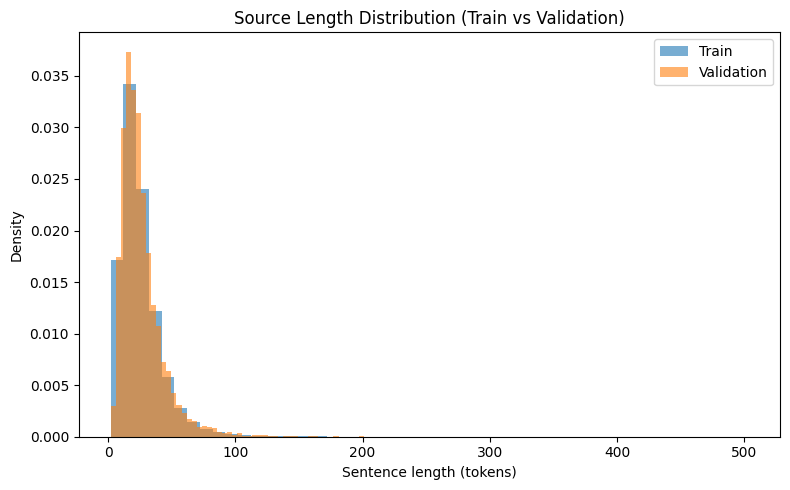

In [9]:
plot_len_dist(
    df_train,
    df_val,
    "src_len",
    "Source Length Distribution (Train vs Validation)"
)


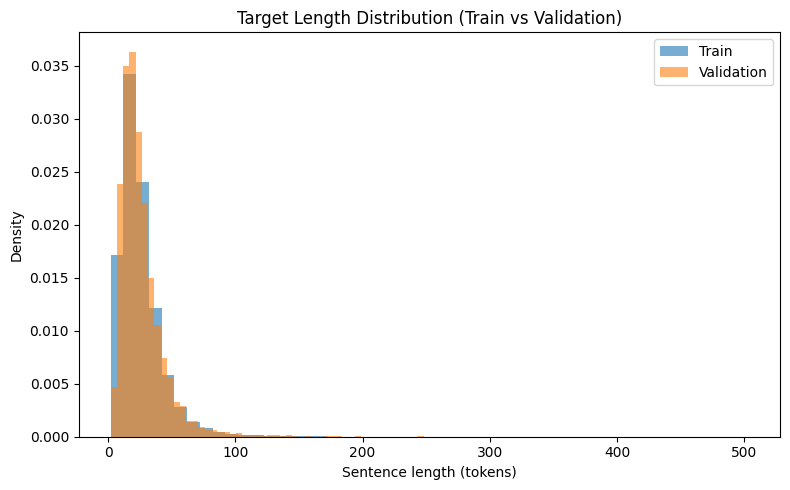

In [10]:
plot_len_dist(
    df_train,
    df_val,
    "tgt_len",
    "Target Length Distribution (Train vs Validation)"
)


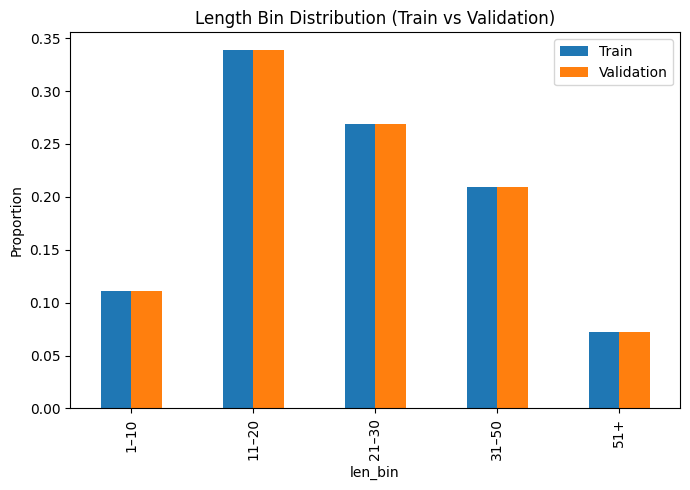

In [11]:
dist_train = df_train["len_bin"].value_counts(normalize=True).sort_index()
dist_val = df_val["len_bin"].value_counts(normalize=True).sort_index()

dist_df = pd.DataFrame({
    "Train": dist_train,
    "Validation": dist_val
})

dist_df.plot(
    kind="bar",
    figsize=(7, 5),
    title="Length Bin Distribution (Train vs Validation)"
)

plt.ylabel("Proportion")
plt.tight_layout()
plt.show()
